In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE



from env import host, user, password
import acquire
import wrangle
import prepare
import cluster
import split_scale


import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('zillow_df.csv')

In [4]:
df = df.drop(df.columns[0], axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59930 entries, 0 to 59929
Data columns (total 17 columns):
longitude         59930 non-null float64
latitude          59930 non-null float64
age               59930 non-null float64
month             59930 non-null int64
bedroomcnt        59930 non-null float64
bathroomcnt       59930 non-null float64
square_footage    59930 non-null float64
lot_size          59930 non-null float64
house_value       59930 non-null float64
land_value        59930 non-null float64
full_value        59930 non-null float64
tax_rate          59930 non-null float64
Los_Angeles       59930 non-null int64
Orange            59930 non-null int64
Ventura           59930 non-null int64
logerror          59930 non-null float64
bed_bath_ratio    59930 non-null float64
dtypes: float64(13), int64(4)
memory usage: 7.8 MB


In [6]:
# X = df[['longitude', 'latitude', 'age', 'month',
#         'square_footage', 'lot_size', 'house_value',
#         'land_value', 'full_value', 'tax_rate',
#         'Los_Angeles', 'Orange', 'Ventura', 'bed_bath_ratio', 'bathroomcnt', 'logerror']]
# y = df[['logerror']]

In [7]:
df.head()

,longitude,latitude,age,month,bedroomcnt,bathroomcnt,square_footage,lot_size,house_value,land_value,full_value,tax_rate,Los_Angeles,Orange,Ventura,logerror,bed_bath_ratio
0,-117869207.0,33634931.0,19.0,1,4.0,3.5,3100.0,4506.0,485713.0,537569.0,1023282.0,0.010763,0,1,0,0.025595,1.142857
1,-119281531.0,34449266.0,50.0,1,2.0,1.0,1465.0,12647.0,88000.0,376000.0,464000.0,0.012225,0,0,1,0.055619,2.000000
2,-117823170.0,33886168.0,55.0,1,3.0,2.0,1243.0,8432.0,85289.0,479489.0,564778.0,0.011488,0,1,0,0.005383,1.500000
3,-118240722.0,34245180.0,47.0,1,4.0,3.0,2376.0,13038.0,108918.0,36225.0,145143.0,0.012247,1,0,0,-0.103410,1.333333
4,-118993991.0,34230044.0,35.0,1,3.0,2.0,1492.0,903.0,198640.0,132424.0,331064.0,0.010596,0,0,1,-0.020526,1.500000


In [8]:
# Split the data
train, test = split_scale.train_test(df)

In [9]:
# Scale the data
scaler, train_scaled, test_scaled = split_scale.min_max_scaler(train, test)

In [10]:
X_train = train_scaled[['latitude', 'longitude', 'age', 'square_footage', 'lot_size', 'full_value']]
y_train = train_scaled[['logerror']]

X_test = test_scaled[['latitude', 'longitude', 'age', 'square_footage', 'lot_size', 'full_value']]
y_test = test_scaled[['logerror']]

In [11]:
# Create linear model
lm = LinearRegression()

In [12]:
# Use Recursive feature selection to find top 3 features
rfe = RFE(lm, 3)

X_rfe = rfe.fit_transform(X_train,y_train)   

In [13]:
# # Look at top 3 features

# mask = rfe.support_

# rfe_features = X_train.columns[mask]
# rfe_features

In [14]:
# Create dataframe of top features in ranking order
var_ranks = rfe.ranking_
var_names = X_train.columns.tolist()

pd.DataFrame({'Feature': var_names, 'Rank': var_ranks}).sort_values(by="Rank")

,Feature,Rank
0,latitude,1
3,square_footage,1
5,full_value,1
2,age,2
1,longitude,3
4,lot_size,4


In [15]:
# Fitting the data to model
lm.fit(X_rfe, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
y_train['y_hat'] = y_train.logerror.mean()
y_train['linear_model_predictions'] = lm.predict(X_rfe)

y_train.head()

,logerror,y_hat,linear_model_predictions
34908,0.824503,0.591585,0.592824
59687,0.574090,0.591585,0.591949
2770,0.590715,0.591585,0.591723
27320,0.587234,0.591585,0.591324
24661,0.590348,0.591585,0.591977


In [17]:
y_train = y_train.rename(columns={'logerror':'actual_logerror'})

In [18]:
y_train

,actual_logerror,y_hat,linear_model_predictions
34908,0.824503,0.591585,0.592824
59687,0.574090,0.591585,0.591949
2770,0.590715,0.591585,0.591723
27320,0.587234,0.591585,0.591324
24661,0.590348,0.591585,0.591977
...,...,...,...
28148,0.591724,0.591585,0.592756
58975,0.550215,0.591585,0.592276
56584,0.599864,0.591585,0.590350
37333,0.586344,0.591585,0.589425


In [19]:
# explained variance using baseline
from sklearn.metrics import explained_variance_score
evs = explained_variance_score(y_train.actual_logerror, y_train.y_hat)
evs

0.0

In [20]:
#explained variance using linear_model_predictions
evs = explained_variance_score(y_train.actual_logerror, y_train.linear_model_predictions)
evs
# (f'evs = {evs:.6f}')

0.0024000625645241858

In [21]:
def model_accuracy(df):
    '''
    This function takes in all the model predictions and baseline predictions 
    and returns a dataframe with each model's evs in order
    '''
    models = df.loc[:, "y_hat":"linear_model_predictions"].columns.tolist()
    models
    
    output = []
    for model in models:
        output.append({
            "model": model,
            "Explained Variance": (f'{explained_variance_score(y_train.actual_logerror, df[model]):6f}')
        })
    
    
    accuracy = pd.DataFrame(output)
    accuracy = accuracy.sort_values(by="Explained Variance", ascending=False)
    return accuracy

In [22]:
metrics = model_accuracy(y_train)

metrics

,model,Explained Variance
1,linear_model_predictions,0.002400
0,y_hat,0.000000


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59930 entries, 0 to 59929
Data columns (total 17 columns):
longitude         59930 non-null float64
latitude          59930 non-null float64
age               59930 non-null float64
month             59930 non-null int64
bedroomcnt        59930 non-null float64
bathroomcnt       59930 non-null float64
square_footage    59930 non-null float64
lot_size          59930 non-null float64
house_value       59930 non-null float64
land_value        59930 non-null float64
full_value        59930 non-null float64
tax_rate          59930 non-null float64
Los_Angeles       59930 non-null int64
Orange            59930 non-null int64
Ventura           59930 non-null int64
logerror          59930 non-null float64
bed_bath_ratio    59930 non-null float64
dtypes: float64(13), int64(4)
memory usage: 7.8 MB


Feature/Target Hypothesis
- $H_0$: Bedroom is not related to logerror
- $H_a$: Bedroom is related to logerror
- alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [32]:
from math import sqrt
from scipy import stats

x = train_scaled.bedroomcnt
y = train_scaled.logerror

alternative_hypothesis = 'Bedroomcount is related to logerror'
alpha = .05

corr, p = stats.pearsonr(x, y)

corr, p

if p < alpha:
    print("We reject the null hypothesis")
    print("We can say that we have confidence that", alternative_hypothesis)
else:
    print("We fail to reject the null")

We reject the null hypothesis
We can say that we have confidence that Bedroomcount is related to logerror


In [25]:
train_scaled.head()

,longitude,latitude,age,month,bedroomcnt,bathroomcnt,square_footage,lot_size,house_value,land_value,full_value,tax_rate,Los_Angeles,Orange,Ventura,logerror,bed_bath_ratio
34908,0.520456,0.522594,0.401042,0.625,0.333333,0.2,0.565886,0.288830,0.608729,0.211115,0.381740,0.558209,1.0,0.0,0.0,0.824503,0.250000
59687,0.776761,0.492830,0.312500,1.000,0.500000,0.2,0.351616,0.245636,0.290725,0.188570,0.241751,0.442803,1.0,0.0,0.0,0.574090,0.357143
2770,0.528157,0.460140,0.244792,0.000,0.500000,0.8,0.632999,0.111914,0.501819,0.803126,0.769668,0.461619,1.0,0.0,0.0,0.590715,0.100000
27320,0.809053,0.373196,0.276042,0.500,0.166667,0.2,0.177703,0.294366,0.131449,0.166743,0.163993,0.459827,0.0,1.0,0.0,0.587234,0.142857
24661,0.931276,0.132273,0.156250,0.500,0.333333,0.4,0.266444,0.353493,0.271492,0.283350,0.303035,0.295169,0.0,1.0,0.0,0.590348,0.142857


### Feature/Feature Hypothesis

#### show relationship between bedroom count and bathroom count 

- $H_0$: Bedroom and bathroom count are not related
- $H_a$: Bedroom and bathroom count are related
- alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [38]:
x = train_scaled.bedroomcnt
y = train_scaled.bathroomcnt

alternative_hypothesis = 'bedroom count is related to bathroom count'
alpha = .05

corr, p = stats.pearsonr(x, y)

corr, p

if p < alpha:
    print("We reject the null hypothesis")
    print("We can say that we have confidence that", alternative_hypothesis)
else:
    print("We fail to reject the null")

We reject the null hypothesis
We can say that we have confidence that bedroom count is related to bathroom count


Value/Target Hypothesis
- $H_0$: Overall house value has no effect on logerror
- $H_a$: Overall house value does have an effect on logerror
- alpha ($\alpha$): 1 - confidence level (95% confidence level -> $\alpha = .05$)

In [40]:
from math import sqrt
from scipy import stats

x = train_scaled.house_value
y = train_scaled.logerror

alternative_hypothesis = 'house value is related to logerror'
alpha = .05

corr, p = stats.pearsonr(x, y)

corr, p

if p < alpha:
    print("We reject the null hypothesis")
    print("We can say that we have confidence that", alternative_hypothesis)
else:
    print("We fail to reject the null")
    
p

We fail to reject the null


0.42749879868985013

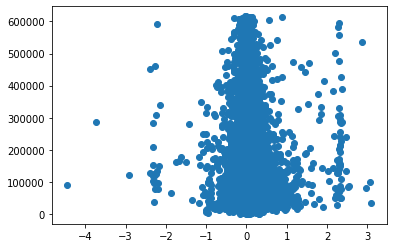

In [42]:
plt.scatter(train.logerror,train.house_value)